In [2]:
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer #Document Word Matrix
from sklearn.model_selection import train_test_split, GridSearchCV  #Split in Trainings und Test Datensatz 
from sklearn.naive_bayes import MultinomialNB #MULTINOMIAL NAIVE BAYES CLASSIFIER
from sklearn.naive_bayes import ComplementNB #COMPLETE NAIVE BAYES 
from sklearn.linear_model import LogisticRegression
import spacy #Tokenizer
from collections import Counter 
from sklearn import metrics #EVALUATION
from sklearn.feature_extraction.text import TfidfVectorizer #TFIDF
import string
from typing import List #Weil beautyyy
import unidecode #PreProcessing
import re #Regular Expressions PreProcessing
from sklearn.svm import SVC #SVM classifier
from sklearn.preprocessing import StandardScaler 
from spacy.tokenizer import Tokenizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score #Bewertungsmetriken 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#setup 

nlp = spacy.load('en_core_web_sm')

try:
    from nltk.corpus import stopwords 
    
except: 
    import nltk 
    nltk.downlaod("stopwords")

finally:
    from nltk.corpus import stopwords 

In [4]:
#Tokenizer
def tokenizer(text):  
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_space]
    return tokens

In [27]:
#CLEANING 

'''def correct_typos(text: str) -> str: #DAUERT SEHR LANGE 
    spell = SpellChecker()
    words = text.split()
    corrected_words = [spell.correction(word) for word in words if spell.correction(word) is not None]
    return ' '.join(corrected_words)'''

def convert_to_lowercase(text: str) -> str:
    return text.lower()

def regex(text: str) -> str:
   
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\'", '', text)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\b\w\b', '', text)
    hashtags = re.findall(r'#\w+', text)
    text += ' '.join(hashtags)   
    return text

def lemmatize(text: str) -> str:
    # Lemmatisierung mit SpaCy
    doc = nlp(text)
    lemmatized_words = []
    for token in doc:
        lemmatized_words.append(token.lemma_)
    
    return " ".join(lemmatized_words)


def remove_stopwords(text: str, sw: List[str] = stopwords.words("english")) -> str: 
    #Eventuell überarbeiten
    additional_sw = ["ubers","uber","drive","gt","get","got","go","ride","make","would","say","driver", "nt", "ca"]
    sw = sw + additional_sw
    text_list = text.split()
    text_list = [word for word in text_list if word.lower() not in sw]
    return " ".join(text_list)

def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
   
    cleaned_text = "".join([char for char in text if char not in punct])
    return cleaned_text

def unicode(text: str) -> str:
    return unidecode.unidecode(text)

def clean(text: str) -> str: #Finale cleaning def
   
    #text = unicode(text)
    #text = regex(text)
    #text = correct_typos(text)
    #text = remove_stopwords(text)
    #text = lemmatize(text)
    text = remove_punctuation(text)
    text = convert_to_lowercase(text)
    
    return text


In [34]:
#DTM erstellen inklusive preprocessing 
cv = CountVectorizer(stop_words='english',ngram_range = (1,1), tokenizer=tokenizer)  
text_counts = cv.fit_transform(df['clean_comment']) #DTM für Spalte

In [28]:
#Einlesen der Daten 
df = pd.read_csv("Reddit_Data_kaggle.csv")
df = df.dropna(subset=["clean_comment"])
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [29]:
#TFIDF
tfidf = TfidfVectorizer(preprocessor=clean, ngram_range=(1,1))
text_count_2 = tfidf.fit_transform(df['clean_comment'])

In [35]:
#Test -und Trainingsdaten erstellen mit TFIDF
X_train, X_test, Y_train, Y_test = train_test_split(text_count_2, df['category'], test_size=0.25, random_state=5)

In [36]:
#Multinomialer Naive Bayes Classifier + Hyperparameter Tuning 
MNB = MultinomialNB()
parameters = {'alpha': [0.1, 0.15 ,0.2 ,0.25 ,0.3 ,0.35 ,0.4 ,0.45, 0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1.0]}  # Liste der zu testenden Hyperparameter-Kombinationen
grid_search = GridSearchCV(MNB, parameters, cv=5, scoring="accuracy")
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_  # Beste Hyperparameter-Kombination
best_score = grid_search.best_score_  # Beste Bewertungsmetrik (Accuracy)
best_model = grid_search.best_estimator_ #Modell definieren
best_model.fit(X_train, Y_train)

Y_pred = best_model.predict(X_test) #Output predicten
print("Beste Hyperparameter: ", best_params) #Werte der Hyperparameter
print("Beste Genauigkeit: {:.2f}%".format(best_score * 100)) #Accuracy
print(classification_report(Y_test, Y_pred))
metrics_mnb = [accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred, average="macro"), recall_score(Y_test, Y_pred, average="macro"), precision_score(Y_test, Y_pred, average="macro")]


Beste Hyperparameter:  {'alpha': 0.25}
Beste Genauigkeit: 64.38%
              precision    recall  f1-score   support

          -1       0.57      0.54      0.55      2096
           0       0.80      0.53      0.64      3187
           1       0.61      0.80      0.70      4005

    accuracy                           0.65      9288
   macro avg       0.66      0.62      0.63      9288
weighted avg       0.67      0.65      0.64      9288



In [37]:
#Complete Naive Bayes + Hyperparamter Tuning 
CNB = ComplementNB()
parameters = {'alpha':[0.1, 0.15 ,0.2 ,0.25 ,0.3 ,0.35 ,0.4 ,0.45, 0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1.0] }  # Liste der zu testenden Hyperparameter-Kombinationen
grid_search = GridSearchCV(CNB, parameters, cv=5, scoring="accuracy")
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_  # Beste Hyperparameter-Kombination
best_score = grid_search.best_score_  # Beste Bewertungsmetrik
best_model = grid_search.best_estimator_
best_model.fit(X_train, Y_train)

Y_pred = best_model.predict(X_test)
print("Beste Hyperparameter: ", best_params)
print("Beste Genauigkeit: {:.2f}%".format(best_score * 100))
print(classification_report(Y_test, Y_pred))
metrics_cnb = [accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred, average="macro"), recall_score(Y_test, Y_pred, average="macro"), precision_score(Y_test, Y_pred, average="macro")]

Beste Hyperparameter:  {'alpha': 0.7}
Beste Genauigkeit: 62.84%
              precision    recall  f1-score   support

          -1       0.54      0.52      0.53      2096
           0       0.72      0.48      0.58      3187
           1       0.64      0.82      0.72      4005

    accuracy                           0.63      9288
   macro avg       0.63      0.61      0.61      9288
weighted avg       0.64      0.63      0.63      9288



In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(X_train, Y_train)
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

#Note: SVC(C=100, gamma=0.01) & TF-IDF besser als ohne BoW

In [33]:
#SVC 
X_train, X_test, Y_train, Y_test = train_test_split(text_count_2, df['category'], test_size=0.25, random_state=5)
svc = SVC(C=100, gamma=0.01)
svc.fit(X_train,Y_train)
Y_pred = svc.predict(X_test)
print(classification_report(Y_test, Y_pred))
metrics_svc = [accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred, average="macro"), recall_score(Y_test, Y_pred, average="macro"), precision_score(Y_test, Y_pred, average="macro")]

              precision    recall  f1-score   support

          -1       0.85      0.76      0.81      2096
           0       0.90      0.97      0.93      3187
           1       0.91      0.90      0.90      4005

    accuracy                           0.89      9288
   macro avg       0.88      0.88      0.88      9288
weighted avg       0.89      0.89      0.89      9288



In [ ]:
grid_predictions = grid.predict(X_test)
  
# print classification report
print(classification_report(Y_test, grid_predictions))
metrics_svc = [accuracy_score(Y_test, grid_predictions), f1_score(Y_test, grid_predicitons), recall_score(Y_test, grid_predictions), precision_score(Y_test, grid_predicitons))

In [16]:
#Logistische Regression 
log_reg = LogisticRegression(random_state=0, max_iter=1000)
log_reg.fit(X_train, Y_train)
Y_pred = log_reg.predict(X_test)
print(classification_report(Y_test, Y_pred))
metrics_lr = [accuracy_score(Y_test, Y_pred), f1_score(Y_test, Y_pred, average="macro"), recall_score(Y_test, Y_pred, average="macro"), precision_score(Y_test, Y_pred, average="macro")]

              precision    recall  f1-score   support

          -1       0.89      0.63      0.74      2096
           0       0.81      0.95      0.88      3187
           1       0.87      0.88      0.87      4005

    accuracy                           0.85      9288
   macro avg       0.86      0.82      0.83      9288
weighted avg       0.85      0.85      0.84      9288



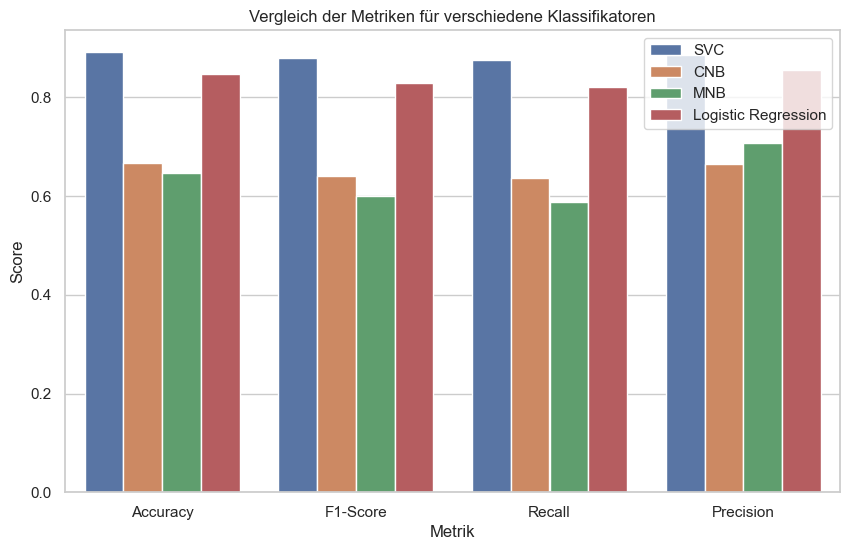

In [18]:
#VISUALISIERUNG 

classifiers = ['SVC', 'CNB', 'MNB', 'Logistic Regression']
metrics = ['Accuracy', 'F1-Score', 'Recall', 'Precision']

# Erstelle ein leeres DataFrame
data = pd.DataFrame()

# Füge die Metriken und Klassifikatoren in das DataFrame ein
for classifier in classifiers:
    for i, metric in enumerate(metrics):
        if classifier == 'SVC':
            score = metrics_svc[i]
        elif classifier == 'CNB':
            score = metrics_cnb[i]
        elif classifier == 'MNB':
            score = metrics_mnb[i]
        elif classifier == 'Logistic Regression':
            score = metrics_lr[i]
        
        df = pd.DataFrame({'Classifier': [classifier], 'Metric': [metric], 'Score': [score]})
        data = pd.concat([data, df], ignore_index=True)

# Erstelle das Balkendiagramm mit Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Classifier', data=data)
plt.title('Vergleich der Metriken für verschiedene Klassifikatoren')
plt.xlabel('Metrik')
plt.ylabel('Score')
plt.legend(loc='upper right')
plt.show()